VIX range: 2010-01-04 → 2025-08-01, obs=4,065

============ RESULTS (Short window=60, Strong prior phi~N(0.9,0.05^2)) ============
Eval obs: 4004
RMSE (Freq):  2.077
RMSE (Bayes): 1.940
Log Predictive Score (Freq):  -1.9974
Log Predictive Score (Bayes): -1.8713
80% PI Coverage (Freq):  85.2%
80% PI Coverage (Bayes): 84.8%
Half-life (days) — medians:
  Freq:  4.01
  Bayes: 5.38


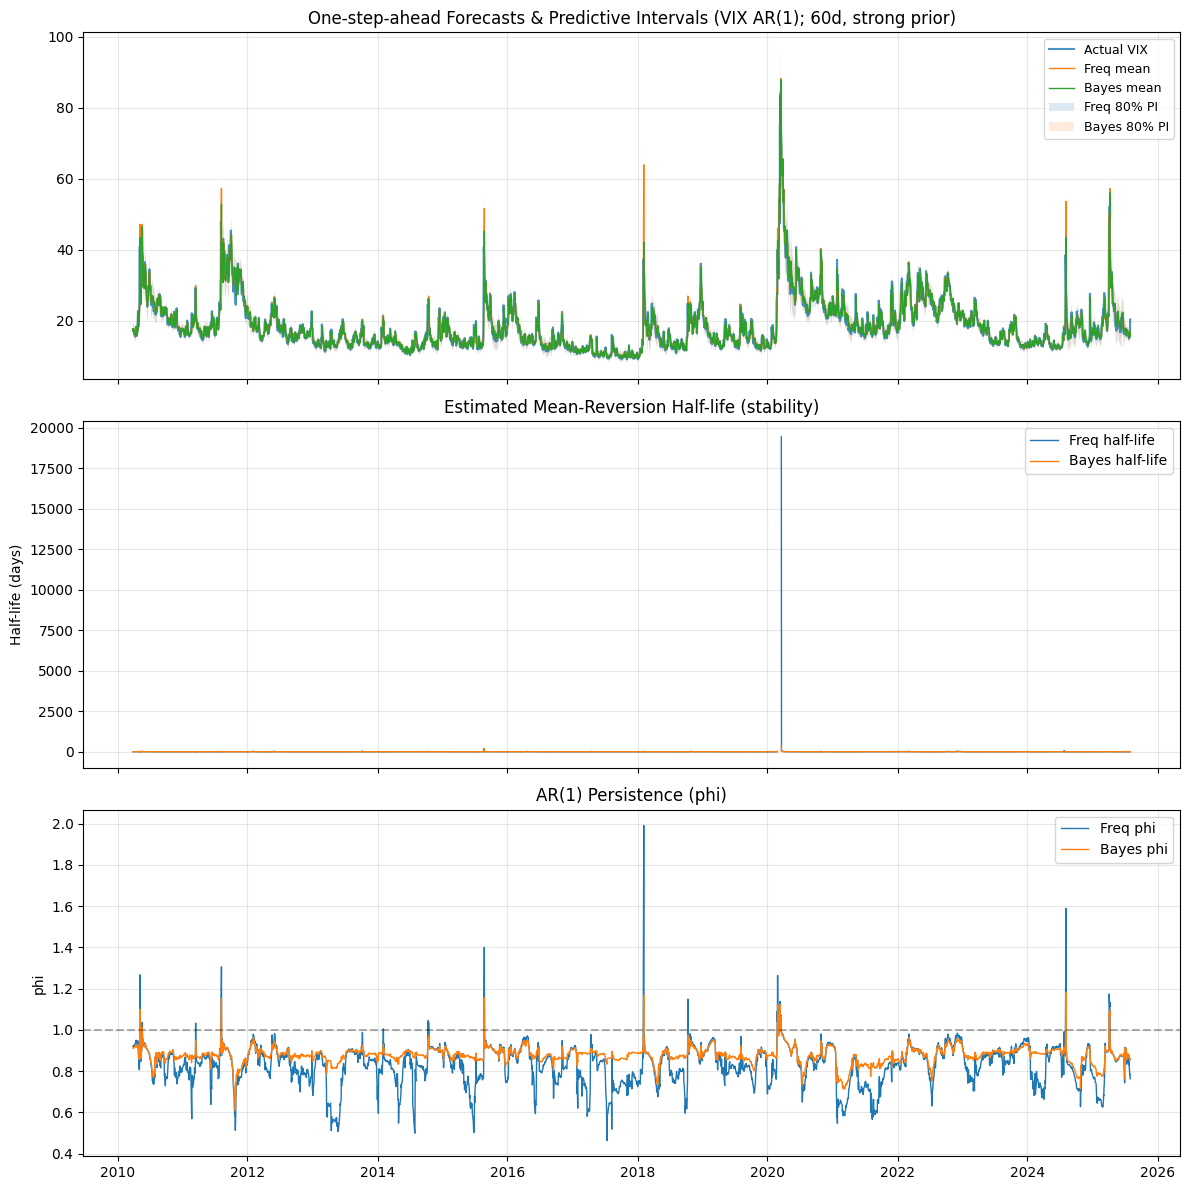

In [43]:
# Bayesian vs Frequentist Mean Reversion on Spot VIX (AR(1), SHORT WINDOW + STRONG PRIOR)
# =======================================================================================
# Changes vs earlier:
#   - Rolling window = 60 business days (was 252)
#   - Strong prior on beta (phi): mean ~ 0.9, sd ~ 0.05  => V0[beta,beta] ≈ (0.05)^2 = 0.0025
#   - Weak prior on alpha (intercept)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from scipy.stats import t as student_t
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

# -----------------------
# 1) Fetch & prepare data
# -----------------------
START = dt.datetime(2010, 1, 1)
END   = dt.datetime(2025, 8, 1)

vix = web.DataReader("VIXCLS", "fred", START, END)["VIXCLS"].dropna()
vix = vix.asfreq("B").ffill()
vix.name = "VIX"

print(f"VIX range: {vix.index[0].date()} → {vix.index[-1].date()}, obs={len(vix):,}")

# -----------------------------
# 2) Helpers: AR(1) reparameter
# -----------------------------
def ols_fit_ar1(y, x_lag):
    """
    y_t = alpha + beta * x_{t-1} + eps
    y, x_lag: 1-D arrays of equal length
    """
    y = np.asarray(y, float).ravel()
    x_lag = np.asarray(x_lag, float).ravel()
    assert y.shape == x_lag.shape and y.ndim == 1

    X = np.column_stack([np.ones_like(x_lag), x_lag])
    XtX = X.T @ X
    XtY = X.T @ y
    beta_hat = np.linalg.solve(XtX, XtY)  # [alpha, beta]
    resid = y - X @ beta_hat
    n, k = X.shape
    sigma2_hat = (resid @ resid) / max(1, (n - k))
    cov_beta = sigma2_hat * np.linalg.pinv(XtX)
    alpha_hat, beta_hat_scalar = beta_hat[0], beta_hat[1]
    mu_hat = np.nan if abs(1 - beta_hat_scalar) < 1e-8 else alpha_hat / (1 - beta_hat_scalar)
    return alpha_hat, beta_hat_scalar, mu_hat, sigma2_hat, cov_beta

# -------------------------------
# 3) Bayesian NIG conjugate update
# -------------------------------
def nig_posterior(X, Y, b0, V0, a0, d0):
    V0_inv = np.linalg.inv(V0)
    XtX = X.T @ X
    XtY = X.T @ Y
    Vn = np.linalg.inv(V0_inv + XtX)
    bn = Vn @ (V0_inv @ b0 + XtY)
    an = a0 + 0.5 * X.shape[0]
    d_numer = (Y.T @ Y) + b0.T @ V0_inv @ b0 - bn.T @ np.linalg.inv(Vn) @ bn
    dn = d0 + 0.5 * d_numer
    return bn, Vn, an, dn

def ar1_params_from_alpha_beta(alpha_beta):
    beta = alpha_beta[1]
    alpha = alpha_beta[0]
    mu = np.nan if abs(1 - beta) < 1e-8 else alpha / (1 - beta)
    phi = beta
    return mu, phi

# ----------------------------------------------------
# 4) Walk-forward: frequentist vs Bayesian forecasting
# ----------------------------------------------------
WINDOW = 60      # <<< short window (boosts estimator noise)
PCT    = 0.80    # predictive interval nominal coverage

# Strong prior:
#   beta (phi) ~ N(0.9, 0.05^2 * sigma^2)  -> V0[1,1] = 0.0025
#   alpha ~ N(0, 100^2 * sigma^2)          -> V0[0,0] = 1e4  (weak on intercept)
b0 = np.array([0.0, 0.9])                 # prior mean for [alpha, beta]
V0 = np.diag([1e4, 0.0025])               # prior covariance scaled by sigma^2 in NIG
a0 = 2.0                                  # IG shape
d0 = 1.0                                  # IG scale

y = vix.values
dates = vix.index

# Storage
freq_pred, freq_pi_lo, freq_pi_hi = [], [], []
freq_mu, freq_phi, freq_sigma2 = [], [], []

bayes_pred_mean, bayes_pred_lo, bayes_pred_hi = [], [], []
bayes_mu, bayes_phi, bayes_df = [], [], []

actual = []

z = 1.2815515655446004  # ~80% two-sided normal quantile

for t in range(WINDOW, len(y) - 1):
    # Window ending at t (inclusive), length WINDOW
    y_window = y[t - WINDOW + 1 : t + 1]
    y_win = y_window[1:]     # y_t
    x_win = y_window[:-1]    # x_{t-1}
    n = len(y_win)
    if n < 5:
        continue

    X = np.column_stack([np.ones(n), x_win])
    Y = y_win

    # ------------------ Frequentist (rolling OLS) ------------------
    a_hat, b_hat, mu_hat, s2_hat, cov_beta = ols_fit_ar1(Y, x_win)
    x_star = np.array([1.0, y[t]])
    yhat = float(x_star @ np.array([a_hat, b_hat]))

    XtX_inv = np.linalg.pinv(X.T @ X)
    pred_var = float(s2_hat * (1.0 + x_star @ XtX_inv @ x_star))
    freq_pred.append(yhat)
    freq_pi_lo.append(yhat - z * np.sqrt(pred_var))
    freq_pi_hi.append(yhat + z * np.sqrt(pred_var))
    freq_mu.append(mu_hat)
    freq_phi.append(b_hat)
    freq_sigma2.append(s2_hat)

    # ---------------------- Bayesian (NIG) -------------------------
    bn, Vn, an, dn = nig_posterior(X, Y, b0, V0, a0, d0)
    df = 2 * an
    pred_mean = float(x_star @ bn)
    pred_scale2 = float((dn / an) * (1.0 + x_star @ Vn @ x_star))

    q_lo = (1 - PCT) / 2
    q_hi = 1 - q_lo
    t_lo = student_t.ppf(q_lo, df=df)
    t_hi = student_t.ppf(q_hi, df=df)

    bayes_pred_mean.append(pred_mean)
    bayes_pred_lo.append(pred_mean + t_lo * np.sqrt(pred_scale2))
    bayes_pred_hi.append(pred_mean + t_hi * np.sqrt(pred_scale2))
    bayes_df.append(df)

    mu_b, phi_b = ar1_params_from_alpha_beta(bn)
    bayes_mu.append(mu_b)
    bayes_phi.append(phi_b)

    actual.append(y[t + 1])

# Align arrays
eval_idx = dates[WINDOW: -1]
actual = np.array(actual)

freq_pred   = np.array(freq_pred)
freq_pi_lo  = np.array(freq_pi_lo)
freq_pi_hi  = np.array(freq_pi_hi)
freq_mu     = np.array(freq_mu)
freq_phi    = np.array(freq_phi)
freq_sigma2 = np.array(freq_sigma2)

bayes_pred_mean = np.array(bayes_pred_mean)
bayes_pred_lo   = np.array(bayes_pred_lo)
bayes_pred_hi   = np.array(bayes_pred_hi)
bayes_mu        = np.array(bayes_mu)
bayes_phi       = np.array(bayes_phi)
bayes_df        = np.array(bayes_df)

# -----------------------------------
# 5) Scoring: RMSE, log score, cover
# -----------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def normal_logpdf(x, mean, var):
    return -0.5*np.log(2*np.pi*var) - 0.5*((x-mean)**2/var)

def student_logpdf(x, mean, scale2, df):
    return student_t.logpdf((x-mean)/np.sqrt(scale2), df=df) - 0.5*np.log(scale2)

# Rebuild per-step pred variances with same alignment
def freq_pred_var_series(y, window):
    out = []
    for t in range(window, len(y) - 1):
        y_window = y[t - window + 1 : t + 1]
        y_win = y_window[1:]
        x_win = y_window[:-1]
        n = len(y_win)
        if n < 5:
            out.append(np.nan); continue
        X = np.column_stack([np.ones(n), x_win])
        a_hat, b_hat, _, s2_hat, _ = ols_fit_ar1(y_win, x_win)
        x_star = np.array([1.0, y[t]])
        XtX_inv = np.linalg.pinv(X.T @ X)
        out.append(float(s2_hat * (1.0 + x_star @ XtX_inv @ x_star)))
    return np.array(out)

def bayes_pred_scale2_series(y, window, b0, V0, a0, d0):
    out = []
    for t in range(window, len(y) - 1):
        y_window = y[t - window + 1 : t + 1]
        y_win = y_window[1:]
        x_win = y_window[:-1]
        n = len(y_win)
        if n < 5:
            out.append(np.nan); continue
        X = np.column_stack([np.ones(n), x_win])
        Y = y_win
        bn, Vn, an, dn = nig_posterior(X, Y, b0, V0, a0, d0)
        x_star = np.array([1.0, y[t]])
        scale2 = float((dn / an) * (1.0 + x_star @ Vn @ x_star))
        out.append(scale2)
    return np.array(out)

freq_pred_var = freq_pred_var_series(y, WINDOW)
bayes_scale2  = bayes_pred_scale2_series(y, WINDOW, b0, V0, a0, d0)

# Mask (should be no NaNs, but safe)
mask = ~(np.isnan(freq_pred) | np.isnan(bayes_pred_mean) | np.isnan(actual))
actual_m = actual[mask]
freq_pred_m = freq_pred[mask]
bayes_pred_mean_m = bayes_pred_mean[mask]
freq_pred_var_m = freq_pred_var[mask]
bayes_scale2_m  = bayes_scale2[mask]
freq_pi_lo_m, freq_pi_hi_m = freq_pi_lo[mask], freq_pi_hi[mask]
bayes_pred_lo_m, bayes_pred_hi_m = bayes_pred_lo[mask], bayes_pred_hi[mask]
eval_idx_m = eval_idx[mask]

freq_rmse  = rmse(actual_m, freq_pred_m)
bayes_rmse = rmse(actual_m, bayes_pred_mean_m)

freq_logscore  = np.mean(normal_logpdf(actual_m, freq_pred_m, freq_pred_var_m))
bayes_logscore = np.mean(student_logpdf(actual_m, bayes_pred_mean_m, bayes_scale2_m, bayes_df[:len(actual_m)]))

freq_cover  = np.mean((actual_m >= freq_pi_lo_m)   & (actual_m <= freq_pi_hi_m))
bayes_cover = np.mean((actual_m >= bayes_pred_lo_m) & (actual_m <= bayes_pred_hi_m))

def halflife_from_phi(phi):
    out = np.full_like(phi, np.nan, dtype=float)
    mask_hl = (phi > 0) & (phi < 1)
    out[mask_hl] = np.log(0.5) / np.log(phi[mask_hl])
    return out

freq_hl  = halflife_from_phi(freq_phi[:len(eval_idx_m)])
bayes_hl = halflife_from_phi(bayes_phi[:len(eval_idx_m)])

print("\n============ RESULTS (Short window=60, Strong prior phi~N(0.9,0.05^2)) ============")
print(f"Eval obs: {len(actual_m)}")
print(f"RMSE (Freq):  {freq_rmse:.3f}")
print(f"RMSE (Bayes): {bayes_rmse:.3f}")
print(f"Log Predictive Score (Freq):  {freq_logscore:.4f}")
print(f"Log Predictive Score (Bayes): {bayes_logscore:.4f}")
print(f"{int(PCT*100)}% PI Coverage (Freq):  {freq_cover*100:.1f}%")
print(f"{int(PCT*100)}% PI Coverage (Bayes): {bayes_cover*100:.1f}%")
print("Half-life (days) — medians:")
print(f"  Freq:  {np.nanmedian(freq_hl):.2f}")
print(f"  Bayes: {np.nanmedian(bayes_hl):.2f}")

# ---------------
# 6) Visuals
# ---------------
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# (A) Forecasts vs actual
axes[0].plot(eval_idx_m, actual_m, label="Actual VIX", lw=1.5, alpha=0.8)
axes[0].plot(eval_idx_m, freq_pred_m, label="Freq mean", lw=1)
axes[0].plot(eval_idx_m, bayes_pred_mean_m, label="Bayes mean", lw=1)
axes[0].fill_between(eval_idx_m, freq_pi_lo_m, freq_pi_hi_m, alpha=0.15, label=f"Freq {int(PCT*100)}% PI")
axes[0].fill_between(eval_idx_m, bayes_pred_lo_m, bayes_pred_hi_m, alpha=0.15, label=f"Bayes {int(PCT*100)}% PI")
axes[0].set_title("One-step-ahead Forecasts & Predictive Intervals (VIX AR(1); 60d, strong prior)")
axes[0].legend(loc="upper right", fontsize=9)
axes[0].grid(alpha=0.3)

# (B) Half-life over time
axes[1].plot(eval_idx_m, freq_hl, label="Freq half-life", lw=1)
axes[1].plot(eval_idx_m, bayes_hl, label="Bayes half-life", lw=1)
axes[1].set_ylabel("Half-life (days)")
axes[1].set_title("Estimated Mean-Reversion Half-life (stability)")
axes[1].legend()
axes[1].grid(alpha=0.3)

# (C) Phi over time
axes[2].plot(eval_idx_m, freq_phi[:len(eval_idx_m)], label="Freq phi", lw=1)
axes[2].plot(eval_idx_m, bayes_phi[:len(eval_idx_m)], label="Bayes phi", lw=1)
axes[2].axhline(1.0, color="k", ls="--", alpha=0.3)
axes[2].set_ylabel("phi")
axes[2].set_title("AR(1) Persistence (phi)")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


VIX range: 2010-01-04 → 2025-08-01, obs=4,065

=== Monetization A: Tail-probability sizing ===


/var/folders/6n/xbpdfg2s7z5_z4t3j_8fzz7r0000gn/T/ipykernel_58640/2719872331.py:208: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ret_sd = ret.rolling(W).std().reindex(idx).fillna(method='bfill').values.astype(float)


Train-selected (Freq): {'param': 0.5, 'k': 1.0, 'Sharpe': 0.591569274753265}
Train-selected (Bayes): {'param': 0.5, 'k': 2.0, 'Sharpe': 0.7466942327404678}
OOS Sharpe — Freq: 0.902 | Bayes: 0.702

=== Monetization B: Information sizing (KL vs baseline) ===
Train-selected (Freq): {'param': None, 'k': 1.5, 'Sharpe': 0.24489495400054673}
Train-selected (Bayes): {'param': None, 'k': 1.0, 'Sharpe': 1.0313539816617163}
OOS Sharpe — Freq: -0.164 | Bayes: 0.846


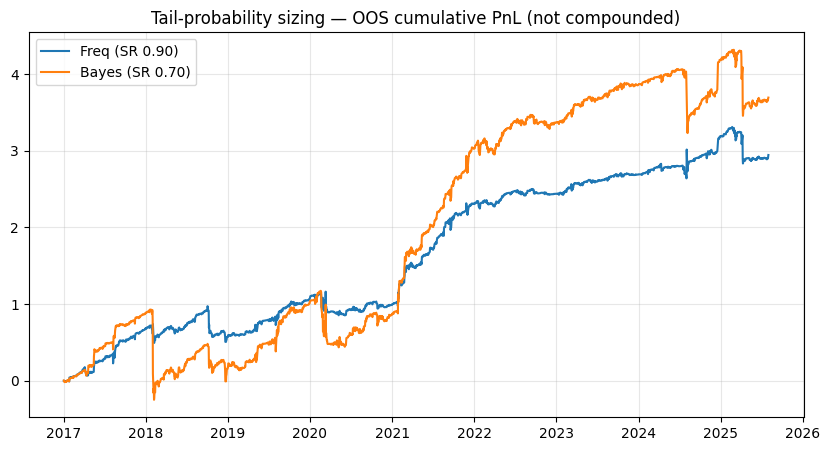

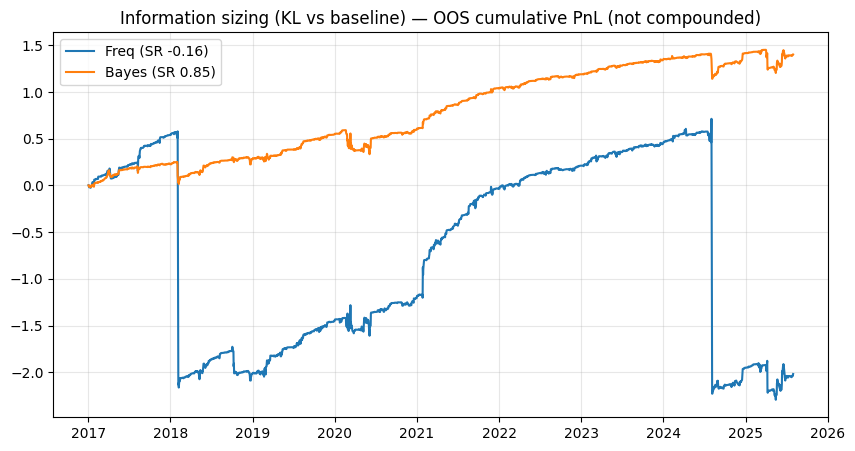

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as web

# =========================
# 0) Data
# =========================
START = dt.datetime(2010, 1, 4)
END   = dt.datetime(2025, 8, 1)
TRAIN_END_DATE = pd.Timestamp("2016-12-30")   # train/valid
RNG = np.random.default_rng(7)

vix = web.DataReader("VIXCLS", "fred", START, END)["VIXCLS"].dropna().asfreq("B").ffill()
vix.name = "VIX"
dates = vix.index
print(f"VIX range: {vix.index[0].date()} → {vix.index[-1].date()}, obs={len(vix):,}")

# =========================
# 1) Core AR(1) helpers on LEVELS
# =========================
def fit_ols_levels(y: np.ndarray):
    """Return beta, s2, XtX_inv for AR(1) on levels over full vector y."""
    y = np.asarray(y, float).ravel()
    y_lag = y[:-1]; y_cur = y[1:]
    n = len(y_cur)
    X = np.column_stack([np.ones(n), y_lag])
    Y = y_cur
    XtX = X.T @ X
    XtX_inv = np.linalg.pinv(XtX)
    beta = np.linalg.solve(XtX, X.T @ Y)
    resid = Y - X @ beta
    k = 2
    s2 = (resid @ resid) / max(1, (n-k))
    return beta, s2, XtX_inv

def freq_predictive_params_level(window_levels: pd.Series):
    """Frequentist predictive for next level: Normal(mean, var) with parameter-uncertainty."""
    y = np.asarray(window_levels, float).ravel()
    beta, s2, XtX_inv = fit_ols_levels(y)
    y_t = y[-1]
    x_star = np.array([1.0, y_t])
    mu_y = float(x_star @ beta)
    var_y = float(s2 * (1.0 + x_star @ XtX_inv @ x_star))
    return y_t, mu_y, var_y

def bayes_predictive_params_level(window_levels: pd.Series,
                                  b0=None, V0=None, a0=2.0, d0=1.0):
    """Bayesian NIG posterior predictive for next level: Student-t with df, mean, scale^2."""
    y = np.asarray(window_levels, float).ravel()
    y_lag = y[:-1]; y_cur = y[1:]
    n = len(y_cur)
    X = np.column_stack([np.ones(n), y_lag]); Y = y_cur

    if b0 is None: b0 = np.array([0.0, 0.9])
    if V0 is None: V0 = np.diag([1e4, 0.0025])   # weak on alpha, moderately informative on phi

    V0_inv = np.linalg.inv(V0)
    XtX = X.T @ X
    XtY = X.T @ Y
    beta_ols = np.linalg.solve(XtX, XtY)
    resid = Y - X @ beta_ols
    sse = resid @ resid

    Vn = np.linalg.inv(V0_inv + XtX)
    bn = Vn @ (V0_inv @ b0 + XtY)
    an = a0 + 0.5 * n
    diff = (beta_ols - b0).reshape(2,1)
    dn = d0 + 0.5 * (sse + (diff.T @ V0_inv @ diff).item())

    # Student-t predictive for LEVEL:
    # df = 2*an
    # mean = x*' bn
    # scale^2 = (dn/an) * (1 + x*' Vn x*)
    y_t = y[-1]
    x_star = np.array([1.0, y_t])
    mu_y = float(x_star @ bn)
    scale2_y = float((dn / an) * (1.0 + x_star @ Vn @ x_star))
    df = 2.0 * an
    return y_t, mu_y, scale2_y, df

# =========================
# 2) Map LEVEL predictive → RETURN predictive
# =========================
def level_params_to_return_freq(y_t, mu_y, var_y):
    mu_r  = (mu_y - y_t) / y_t
    sd_r  = np.sqrt(max(var_y, 1e-18)) / y_t
    return mu_r, sd_r

def level_params_to_return_bayes(y_t, mu_y, scale2_y, df):
    mu_r = (mu_y - y_t) / y_t
    sd_r = np.sqrt(max(scale2_y, 1e-18)) / y_t   # Student-t scale parameter
    return mu_r, sd_r, df

# =========================
# 3) Log pdf utilities (Normal & Student-t), sampling
# =========================
def normal_logpdf(x, mu, sd):
    z = (x - mu) / sd
    return -0.5*(np.log(2*np.pi) + 2*np.log(sd) + z*z)

def student_t_logpdf(x, mu, s, df):
    # location-scale t: x = mu + s * T, T ~ t_df
    z2 = ((x - mu) / s)**2
    return (np.log(np.exp(np.log(np.math.gamma((df+1)/2)) - np.log(np.math.gamma(df/2))) )
            -0.5*np.log(df*np.pi) - np.log(s)
            - 0.5*(df+1)*np.log1p(z2/df))

# vectorized gamma logs to avoid math.gamma overflow for arrays:
from math import lgamma
def student_t_logpdf_vec(x, mu, s, df):
    x = np.asarray(x, float)
    c = lgamma((df+1)/2) - lgamma(df/2) - 0.5*np.log(df*np.pi) - np.log(s)
    z2 = ((x - mu) / s)**2
    return c - 0.5*(df+1)*np.log1p(z2/df)

def sample_freq_returns(mu_r, sd_r, n, rng):
    return rng.normal(mu_r, sd_r, size=n)

def sample_bayes_returns(mu_r, sd_r, df, n, rng):
    # sample T ~ t_df via Normal/Gamma: T = Z / sqrt(G/df), Z~N(0,1), G~Chi2_df
    Z = rng.standard_normal(n)
    G = rng.chisquare(df, size=n)
    T = Z / np.sqrt(G/df)
    return mu_r + sd_r * T

# =========================
# 4) Walk-forward predictive streams (parameters)
# =========================
def walk_forward_params(vix_series, W=60, rng=RNG):
    """Return per-step predictive PARAMS for both models in RETURN space."""
    vix = vix_series.values.astype(float)
    dates = vix_series.index
    mu_sd_freq = []      # (date_t, mu_r, sd_r)
    mu_sd_df_b = []      # (date_t, mu_r, sd_r, df)

    for t in range(W, len(vix)-1):
        window = pd.Series(vix[t-W:t+1], index=dates[t-W:t+1])
        # Frequentist params
        y_t, mu_y, var_y = freq_predictive_params_level(window)
        mu_r_f, sd_r_f = level_params_to_return_freq(y_t, mu_y, var_y)
        mu_sd_freq.append((dates[t], mu_r_f, sd_r_f))

        # Bayesian params
        y_t2, mu_y_b, scale2_y_b, df_b = bayes_predictive_params_level(window)
        mu_r_b, sd_r_b, df_b2 = level_params_to_return_bayes(y_t2, mu_y_b, scale2_y_b, df_b)
        mu_sd_df_b.append((dates[t], mu_r_b, sd_r_b, df_b2))
    return mu_sd_freq, mu_sd_df_b

# =========================
# 5) Monetizations
# =========================
def tail_prob_position(mu, sd, draws, tau_pts, y_t, k, rng, df=None):
    """Position = k * (P(Δ>τ) - P(Δ<-τ)), where τ is in VIX points → convert to returns by τ/y_t."""
    tau_r = tau_pts / y_t
    if df is None:
        r_samp = sample_freq_returns(mu, sd, draws, rng)
    else:
        r_samp = sample_bayes_returns(mu, sd, df, draws, rng)
    p_up = np.mean(r_samp >  tau_r)
    p_dn = np.mean(r_samp < -tau_r)
    return k * (p_up - p_dn)

def info_position(mu, sd, draws, y_t, k, rng, df=None, baseline_sd=None):
    """
    Information sizing: w = k * KL(p||q) * sign(E_p[r]).
    - p is model predictive (Normal or Student-t)
    - q is baseline Normal(0, baseline_sd^2) on returns
    KL is estimated by MC: E_p[log p - log q]
    """
    if baseline_sd is None or baseline_sd <= 0:
        return 0.0
    # sample r from p
    if df is None:
        r_samp = sample_freq_returns(mu, sd, draws, rng)
        lp_p = normal_logpdf(r_samp, mu, sd)
    else:
        r_samp = sample_bayes_returns(mu, sd, df, draws, rng)
        lp_p = student_t_logpdf_vec(r_samp, mu, sd, df)
    lp_q = normal_logpdf(r_samp, 0.0, baseline_sd)
    KL = float(np.mean(lp_p - lp_q))
    sign_dir = np.sign(np.mean(r_samp))
    return k * KL * sign_dir

# =========================
# 6) Backtest harness (train→select→test)
# =========================
def run_strategy(vix_series,
                 monetization="tail",      # "tail" or "info"
                 W=60,
                 draws=1000,
                 k_grid=(0.5, 1.0, 1.5),
                 tau_pts_grid=(0.5, 1.0, 2.0, 3.0),
                 seed=7):
    rng = np.random.default_rng(seed)
    mu_sd_f, mu_sd_b = walk_forward_params(vix_series, W=W, rng=rng)

    # Build aligned arrays and realized returns
    # Note: each entry corresponds to date t (forecast for t+1)
    idx = [d for (d, *_ ) in mu_sd_f]
    vix = vix_series.reindex(vix_series.index)  # ensure alignment
    r_next = (vix.shift(-1) - vix) / vix
    r_next = r_next.reindex(idx).values.astype(float)

    # Rolling baseline sd of returns for info sizing
    ret = vix.pct_change().dropna()
    ret_sd = ret.rolling(W).std().reindex(idx).fillna(method='bfill').values.astype(float)

    # Pack per-step params
    y_t_vals = vix.reindex(idx).values.astype(float)
    mu_f = np.array([m for (_, m, _) in mu_sd_f], float)
    sd_f = np.array([s for (_, _, s) in mu_sd_f], float)
    mu_b = np.array([m for (_, m, _, _) in mu_sd_b], float)
    sd_b = np.array([s for (_, _, s, _) in mu_sd_b], float)
    df_b = np.array([df for (_, _, _, df) in mu_sd_b], float)

    # Split train/test
    idx_series = pd.Series(index=idx, data=np.arange(len(idx)))
    train_mask = (pd.Index(idx) <= TRAIN_END_DATE)
    test_mask  = ~train_mask

    def eval_grid(model="freq"):
        best = {"param": None, "k": None, "Sharpe": -np.inf}
        for k in k_grid:
            if monetization == "tail":
                for tau_pts in tau_pts_grid:
                    pos = np.zeros_like(r_next)
                    for i in range(len(pos)):
                        if model == "freq":
                            pos[i] = tail_prob_position(mu_f[i], sd_f[i], draws, tau_pts, y_t_vals[i], k, rng, df=None)
                        else:
                            pos[i] = tail_prob_position(mu_b[i], sd_b[i], draws, tau_pts, y_t_vals[i], k, rng, df=df_b[i])
                    pnl = pos[train_mask] * r_next[train_mask]
                    sr = np.sqrt(252) * np.nanmean(pnl) / (np.nanstd(pnl, ddof=1) + 1e-12)
                    if sr > best["Sharpe"]:
                        best = {"param": tau_pts, "k": k, "Sharpe": sr}
            else:  # monetization == "info"
                for k_only in [k]:   # just to mirror structure
                    pos = np.zeros_like(r_next)
                    for i in range(len(pos)):
                        if model == "freq":
                            pos[i] = info_position(mu_f[i], sd_f[i], draws, y_t_vals[i], k_only, rng, df=None, baseline_sd=ret_sd[i])
                        else:
                            pos[i] = info_position(mu_b[i], sd_b[i], draws, y_t_vals[i], k_only, rng, df=df_b[i], baseline_sd=ret_sd[i])
                    pnl = pos[train_mask] * r_next[train_mask]
                    sr = np.sqrt(252) * np.nanmean(pnl) / (np.nanstd(pnl, ddof=1) + 1e-12)
                    if sr > best["Sharpe"]:
                        best = {"param": None, "k": k_only, "Sharpe": sr}
        return best

    # Select per-model best monetization on TRAIN
    best_freq = eval_grid("freq")
    best_bayes = eval_grid("bayes")

    # Build TEST pnl using each model's own best params
    def build_pnl(model, param, k):
        pos = np.zeros_like(r_next)
        for i in range(len(pos)):
            if monetization == "tail":
                if model == "freq":
                    pos[i] = tail_prob_position(mu_f[i], sd_f[i], draws, param, y_t_vals[i], k, RNG, df=None)
                else:
                    pos[i] = tail_prob_position(mu_b[i], sd_b[i], draws, param, y_t_vals[i], k, RNG, df=df_b[i])
            else:
                if model == "freq":
                    pos[i] = info_position(mu_f[i], sd_f[i], draws, y_t_vals[i], k, RNG, df=None, baseline_sd=ret_sd[i])
                else:
                    pos[i] = info_position(mu_b[i], sd_b[i], draws, y_t_vals[i], k, RNG, df=df_b[i], baseline_sd=ret_sd[i])
        pnl = pos[test_mask] * r_next[test_mask]
        sr  = np.sqrt(252) * np.nanmean(pnl) / (np.nanstd(pnl, ddof=1) + 1e-12)
        return pnl, sr, pos, test_mask

    pnl_freq, sr_freq, pos_freq, mask = build_pnl("freq", best_freq["param"], best_freq["k"])
    pnl_baye, sr_baye, pos_baye, _    = build_pnl("bayes", best_bayes["param"], best_bayes["k"])

    return {
        "best_freq": best_freq,
        "best_bayes": best_bayes,
        "sr_test_freq": sr_freq,
        "sr_test_bayes": sr_baye,
        "pnl_test_freq": pnl_freq,
        "pnl_test_bayes": pnl_baye,
        "dates_test": np.array(idx)[test_mask],
    }

# =========================
# 7) Run both monetizations
# =========================
W = 60
DRAWS = 1000

print("\n=== Monetization A: Tail-probability sizing ===")
res_tail = run_strategy(vix, monetization="tail", W=W, draws=DRAWS,
                        k_grid=(0.5, 1.0, 1.5, 2.0),
                        tau_pts_grid=(0.5, 1.0, 2.0, 3.0), seed=11)
print("Train-selected (Freq):", res_tail["best_freq"])
print("Train-selected (Bayes):", res_tail["best_bayes"])
print(f"OOS Sharpe — Freq: {res_tail['sr_test_freq']:.3f} | Bayes: {res_tail['sr_test_bayes']:.3f}")

print("\n=== Monetization B: Information sizing (KL vs baseline) ===")
res_info = run_strategy(vix, monetization="info", W=W, draws=DRAWS,
                        k_grid=(0.5, 1.0, 1.5, 2.0), seed=13)
print("Train-selected (Freq):", res_info["best_freq"])
print("Train-selected (Bayes):", res_info["best_bayes"])
print(f"OOS Sharpe — Freq: {res_info['sr_test_freq']:.3f} | Bayes: {res_info['sr_test_bayes']:.3f}")

# =========================
# 8) (Optional) Plot cumulative PnL for one monetization
# =========================
def plot_cum_pnl(res, title):
    pnl_f = np.asarray(res["pnl_test_freq"], float).ravel()
    pnl_b = np.asarray(res["pnl_test_bayes"], float).ravel()
    eq_f  = np.cumsum(pnl_f)
    eq_b  = np.cumsum(pnl_b)
    dt    = pd.to_datetime(res["dates_test"])
    plt.figure(figsize=(10,5))
    plt.plot(dt, eq_f, label=f"Freq (SR {res['sr_test_freq']:.2f})")
    plt.plot(dt, eq_b, label=f"Bayes (SR {res['sr_test_bayes']:.2f})")
    plt.title(title + " — OOS cumulative PnL (not compounded)")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

plot_cum_pnl(res_tail, "Tail-probability sizing")
plot_cum_pnl(res_info, "Information sizing (KL vs baseline)")
